Dataset: https://www.kaggle.com/volpatto/temperature-timeseries-for-some-brazilian-cities

# Preparando os dados

In [0]:
import pandas as pd

arquivo = 'https://raw.githubusercontent.com/jhklarcher/data-science/master/datasets/station_curitiba.csv' # Nome e local do arquivo
df = pd.read_csv(arquivo)

In [2]:
df.shape

(59, 18)

In [3]:
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1961,21.80,21.84,20.51,19.14,16.05,14.87,15.43,17.17,18.56,19.53,20.56,20.81,21.52,18.57,15.82,19.55,18.86
1,1962,20.47,20.29,20.78,17.42,14.49,12.19,12.29,14.85,16.46,15.48,19.07,20.01,20.52,17.56,13.11,17.00,17.05
2,1963,22.57,21.41,22.06,18.82,15.71,13.76,15.62,16.20,19.65,18.50,20.37,19.79,21.33,18.86,15.19,19.51,18.72
3,1964,21.33,21.57,20.29,19.26,15.46,13.03,12.08,14.97,16.93,17.28,17.76,19.47,20.90,18.34,13.36,17.32,17.48
4,1965,20.31,21.99,19.11,18.61,15.12,16.17,13.94,16.55,17.66,18.23,19.84,20.92,20.59,17.61,15.55,18.58,18.08


In [0]:
df = df.iloc[:, :-5]

In [0]:
df = pd.melt(df, id_vars=['YEAR'])

In [6]:
df.head()

,YEAR,variable,value
0,1961,JAN,21.80
1,1962,JAN,20.47
2,1963,JAN,22.57
3,1964,JAN,21.33
4,1965,JAN,20.31


In [0]:
df['date'] = df['YEAR'].astype(str)+'/'+ df['variable']

In [8]:
df.head()

,YEAR,variable,value,date
0,1961,JAN,21.80,1961/JAN
1,1962,JAN,20.47,1962/JAN
2,1963,JAN,22.57,1963/JAN
3,1964,JAN,21.33,1964/JAN
4,1965,JAN,20.31,1965/JAN


In [0]:
df = df.drop(['YEAR', 'variable'], axis=1)

In [0]:
df['date'] = pd.to_datetime(df['date'])
df.columns = ['y', 'ds']

In [0]:
df = (df.sort_values('ds')).reset_index(drop=True)

In [12]:
df

,y,ds
0,21.80,1961-01-01
1,21.84,1961-02-01
2,20.51,1961-03-01
3,19.14,1961-04-01
4,16.05,1961-05-01
...,...,...
703,16.10,2019-08-01
704,18.00,2019-09-01
705,21.25,2019-10-01
706,999.90,2019-11-01


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       708 non-null    float64       
 1   ds      708 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.2 KB


In [14]:
df.describe()

,y
count,708.000000
mean,146.198729
std,330.165513
min,12.080000
25%,16.457500
50%,19.650000
75%,22.152500
max,999.900000


In [0]:
df = df[df['y']<500]

# Modelo

In [0]:
df_test = df.iloc[-13:-1, :]
df_train = df.iloc[:-13, :]

In [0]:
from fbprophet import Prophet

In [18]:
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
preds = m.predict(df_test)

## Calculando o erro médio absoluto das previsões

In [20]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(preds['yhat'], df_test['y'])

0.9251765066125502

O erro é de menos de 1°C

## Visualizando os valores previstos pelo modelo

Pontos dados pelo modelo e pontos previstos.

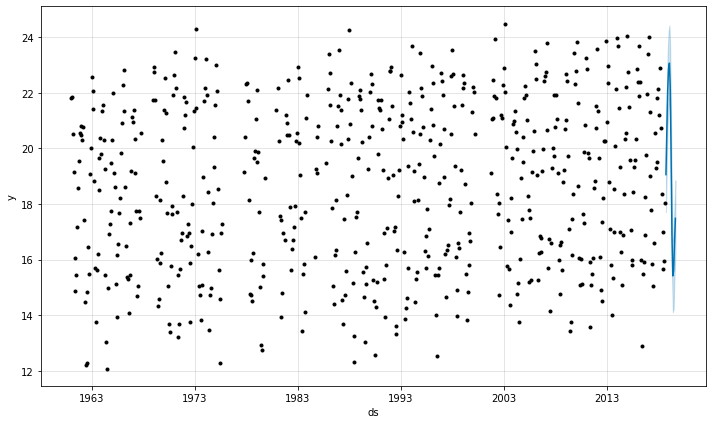

In [21]:
p1 = m.plot(preds)

Componentes do modelo

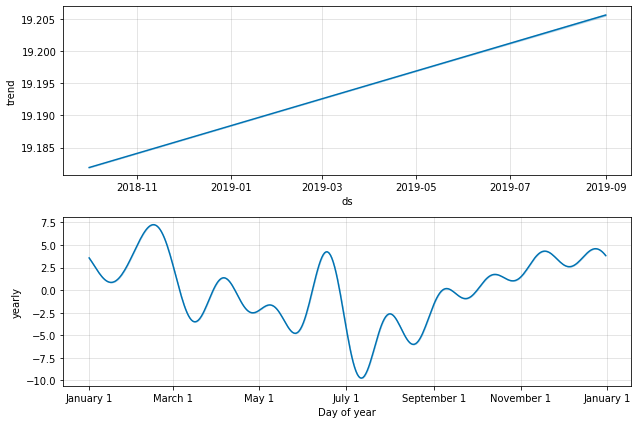

In [22]:
p2 = m.plot_components(preds)

Diferença entre previsto e modelo.

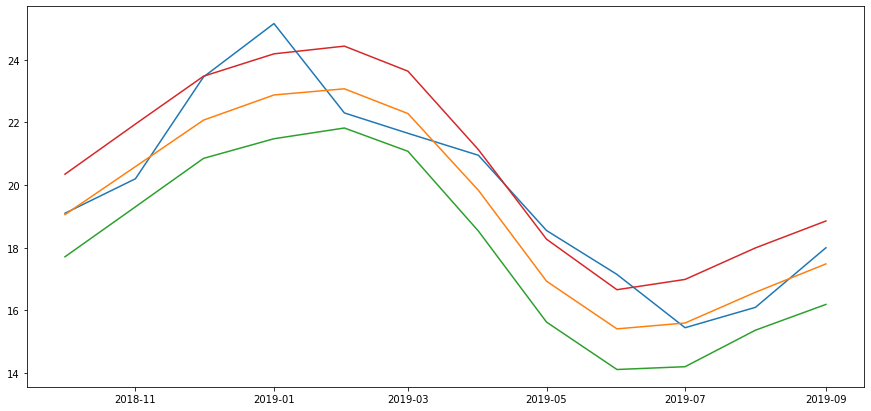

In [23]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

plt.plot(df_test['ds'], df_test['y'])
plt.plot(df_test['ds'], preds['yhat'])
plt.plot(df_test['ds'], preds['yhat_lower'])
plt.plot(df_test['ds'], preds['yhat_upper'])

Previsão para o ano seguinte

In [24]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m.make_future_dataframe(periods=13, freq='M')

In [26]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
624,2020-06-30,15.965990,14.576056,17.310728
625,2020-07-31,16.713248,15.360735,18.026513
626,2020-08-31,17.603554,16.315133,19.041147
627,2020-09-30,19.334160,18.004484,20.665731
628,2020-10-31,20.727181,19.457397,22.021046


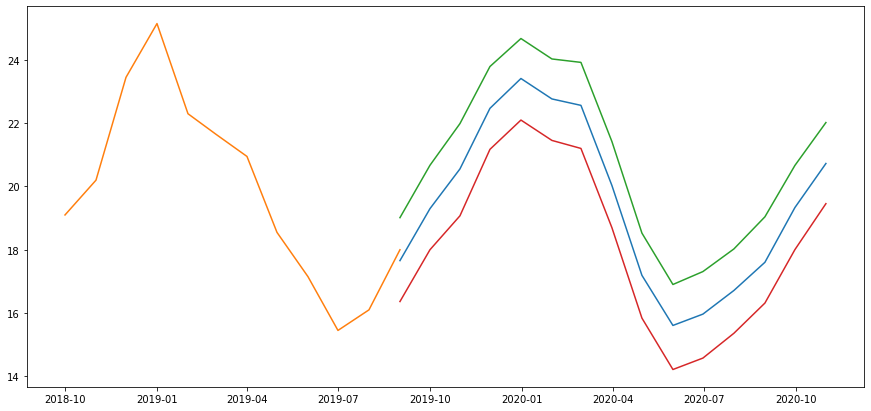

In [27]:
plt.plot(forecast.tail(15)['ds'], forecast.tail(15)['yhat'])
plt.plot(df_test['ds'], df_test['y'])
plt.plot(forecast.tail(15)['ds'], forecast.tail(15)['yhat_upper'])
plt.plot(forecast.tail(15)['ds'], forecast.tail(15)['yhat_lower'])
